In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.io import read_image
import glob
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


## Load the trained XceptionNet + Celeb-DF-v2 model

In [3]:
checkpoint = torch.load('./CelebDF_100epochs.pt',map_location=torch.device('cuda'))
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Initialize and process test dataset

In [4]:
class CustomDataset(Dataset):
	def __init__(self, transform=None):
		self.imgs_path = './Celeb-DF-v2_test/'
		self.transform = transform
		file_list = glob.glob(self.imgs_path + "*")
		
		self.data = []
		for class_path in file_list:
			# class_name = class_path.split("\\")[-1]
			class_name = class_path.split("/")[-1]
			print(class_name)
			for img_path in glob.glob(class_path + "/*.jpg"):
				self.data.append([img_path, class_name])
			
		self.class_map = {"Real": 0, "Fake": 1}
	
	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		img_path, class_name = self.data[idx]
		img = read_image(img_path)
		class_id = self.class_map[class_name]
		class_id = torch.tensor([class_id])

		# Transform if necessary
		if self.transform:
				img_tensor = self.transform(img)
		return img_tensor, class_id

In [5]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
     ])

dataset = CustomDataset(transform=train_transforms)
train_size = 0
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])	

train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(len(test_data_loader))

Real
Fake
48


## Evaluation and Prediction on model

In [6]:
model.eval()
predicted_labels = []
actual_labels = []
predicted_probabilities = []

with torch.no_grad():
    for i, data in enumerate(test_data_loader):
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        output = torch.sigmoid(output)
        predicted_label = (output > 0.5).int()

        predicted_probabilities.append(output.item())
        predicted_labels.append(predicted_label.item())
        actual_labels.append(labels.item())
        print(f"{output.item()}, Predicted: {'Fake' if predicted_label.item() == 1 else 'Real'}, Actual: {'Fake' if labels.item() == 1 else 'Real'}")

8.523189535480924e-06, Predicted: Real, Actual: Real
1.0, Predicted: Fake, Actual: Fake
7.475021993741393e-05, Predicted: Real, Actual: Real
0.0003996420418843627, Predicted: Real, Actual: Real
2.7350009986548685e-05, Predicted: Real, Actual: Real
8.581157453591004e-05, Predicted: Real, Actual: Real
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
0.04182044789195061, Predicted: Real, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.3654791473527439e-05, Predicted: Real, Actual: Real
1.725592665025033e-05, Predicted: Real, Actual: Real
1.9767861886066385e-05, Predicted: Real, Actual: Real
0.9999998807907104, Predicted: Fake, Actual: Fake
1.836102455854416e-05, Predicted: Real, Actual: Real
0.9999998807907104, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
0.9999998807907104, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
5.117236469232012e-06, Predicted: Real,

In [7]:
print("Predicted labels:")
print(predicted_labels[:20])
print("Actual labels:")
print(actual_labels[:20])

print(classification_report(actual_labels, predicted_labels))

Predicted labels:
[0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]
Actual labels:
[0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      0.94      0.97        32

    accuracy                           0.96        48
   macro avg       0.94      0.97      0.95        48
weighted avg       0.96      0.96      0.96        48



## Show Confusion Matrix

Confusion Matrix:
[[16  0]
 [ 2 30]]

Metrics:
Precision: 1.0000
Recall: 0.9375
F1 Score: 0.9677
Accuracy: 0.9583
False Positive Rate (FPR): 0.0000
False Negative Rate (FNR): 0.0625



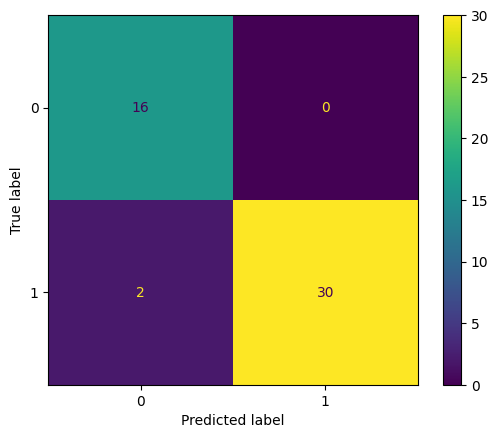

In [8]:
# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Compute metrics
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

# Prepare results
results = f"""Confusion Matrix:
{cm}

Metrics:
Precision: {precision:.4f}
Recall: {recall:.4f}
F1 Score: {f1_score:.4f}
Accuracy: {accuracy:.4f}
False Positive Rate (FPR): {fpr:.4f}
False Negative Rate (FNR): {fnr:.4f}
"""

# Save results to a text file
file_path = "./confusion_matrix_celebdf_100epochs.txt"
with open(file_path, "w") as file:
    file.write(results)

# Print results
print(results)

# Display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig('./confusion_matrix_celebdf_100epochs')
plt.show()


## Plot Prediction Curves

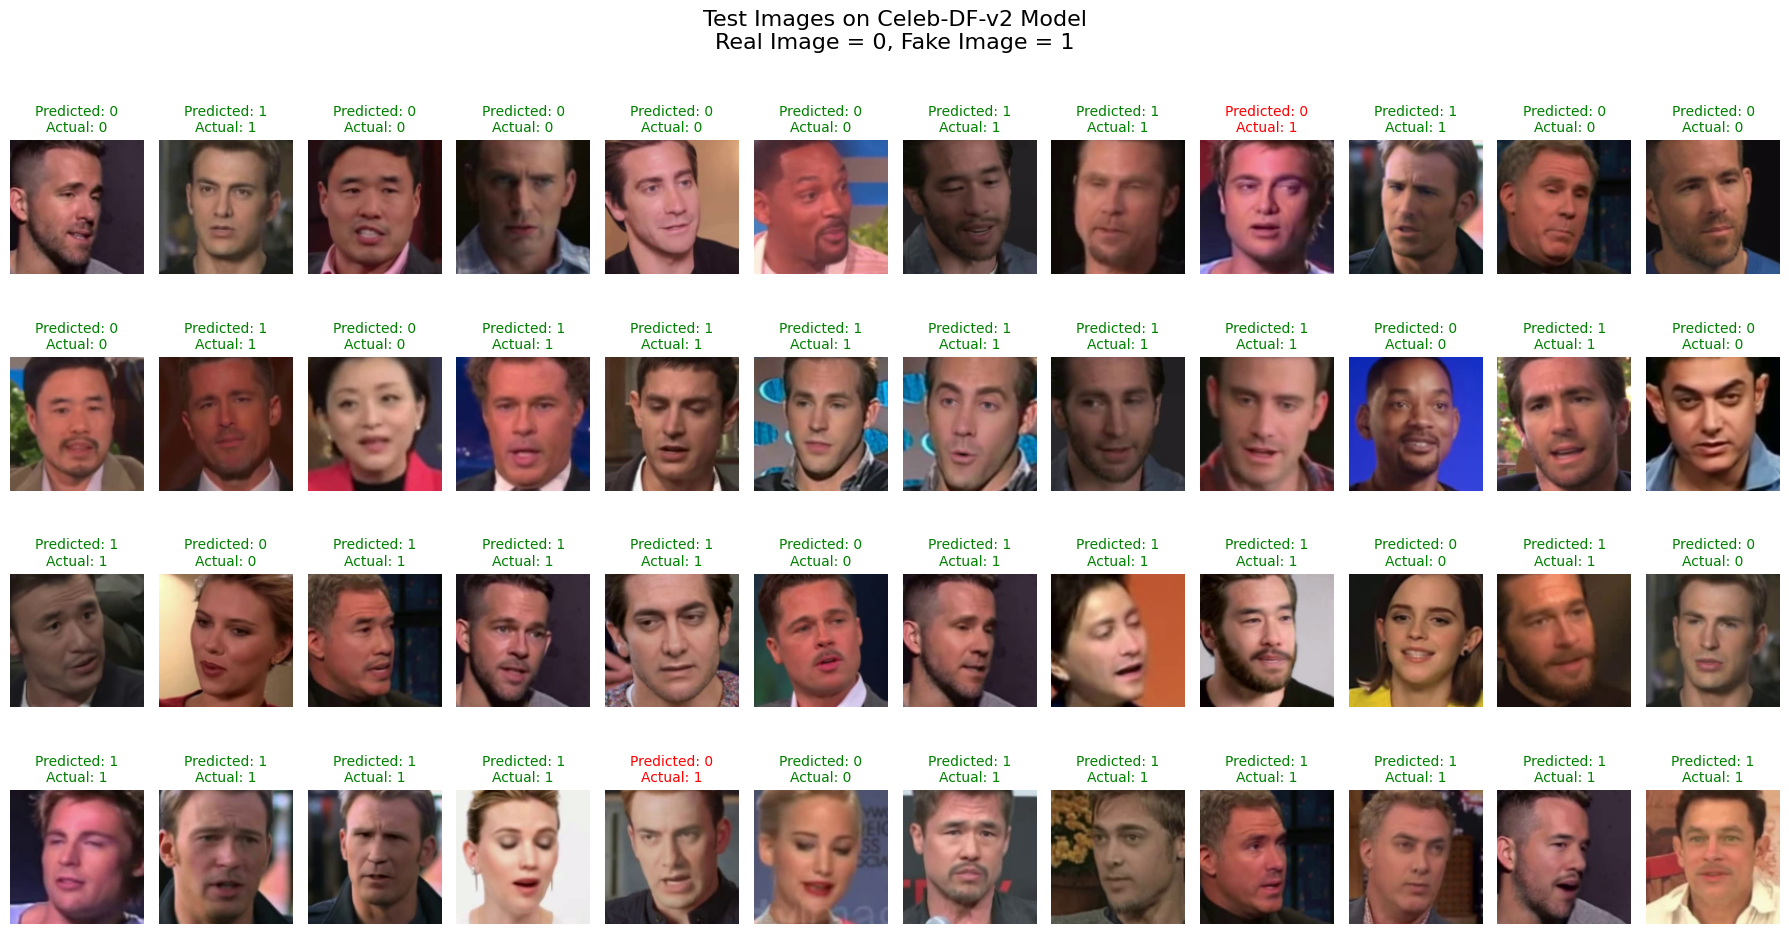

In [10]:
def plot_test_images(test_data_loader, predicted_labels, actual_labels):
    """
    Displays test images with predicted and actual labels.
    
    Parameters:
    - test_data_loader: PyTorch DataLoader object containing test data.
    - predicted_labels: List or array of predicted labels.
    - actual_labels: List or array of actual labels.
    """
    # Get the total length of the dataset
    num_images = len(test_data_loader.dataset)
    
    predicted_labels = np.array(predicted_labels)
    actual_labels = np.array(actual_labels)
    
    num_images = min(num_images, len(predicted_labels), len(actual_labels))
    
    cols = 12  # Set the number of columns to 12
    rows = (num_images + cols - 1) // cols  # Dynamically calculate the number of rows
    fig, axs = plt.subplots(rows, cols, figsize=(18, 10))  # Increase figure size
    fig.suptitle('Test Images on Celeb-DF-v2 Model\nReal Image = 0, Fake Image = 1', fontsize=16)
    
    axs = axs.flatten()
    
    img_idx = 0  # Image counter
    for batch in test_data_loader:
        data, labels = batch  # Retrieve data and labels
        batch_size = data.size(0)
        
        for i in range(batch_size):
            if img_idx >= num_images:
                break  # Desired number of images displayed
            
            # Move the image to CPU and convert to a NumPy array
            image = data[i].cpu().numpy().transpose((1, 2, 0))
            
            # Normalize the image to the range [0, 1] (if needed)
            image = np.clip(image, 0, 1)
            
            # Add the image to the subplot
            axs[img_idx].imshow(image)
            axs[img_idx].axis('off')  # Hide axes
            
            # Add predicted and actual labels as the title
            predicted = predicted_labels[img_idx]
            actual = actual_labels[img_idx]
            title_color = 'green' if predicted == actual else 'red'  # Green if correct, red if incorrect
            axs[img_idx].set_title(f'Predicted: {predicted}\nActual: {actual}', fontsize=10, color=title_color)
            
            img_idx += 1  # Increment the counter
    
        if img_idx >= num_images:
            break  # Desired number of images displayed
    
    # Hide remaining subplots (if any)
    for j in range(img_idx, len(axs)):
        axs[j].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Leave space for the overall title
    plt.savefig("predicted_celebdf_100epochs.png")
    plt.show()


plot_test_images(test_data_loader, predicted_labels, actual_labels)


## Load the trained XceptionNet + FaceForensics++ model

In [25]:
checkpoint = torch.load('./FF_100epochs.pt',map_location=torch.device('cuda'))
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [26]:
class CustomDataset(Dataset):
	def __init__(self, transform=None):
		self.imgs_path = '/home/utku/AI-Powered-Deepfake-Detection/FaceForensics_test/'
		self.transform = transform
		file_list = glob.glob(self.imgs_path + "*")
		
		self.data = []
		for class_path in file_list:
			# class_name = class_path.split("\\")[-1]
			class_name = class_path.split("/")[-1]
			print(class_name)
			for img_path in glob.glob(class_path + "/*.jpg"):
				self.data.append([img_path, class_name])
			
		self.class_map = {"Real": 0, "Fake": 1}
	
	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		img_path, class_name = self.data[idx]
		img = read_image(img_path)
		class_id = self.class_map[class_name]
		class_id = torch.tensor([class_id])

		if self.transform:
				img_tensor = self.transform(img)
		return img_tensor, class_id

In [27]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
     ])

dataset = CustomDataset(transform=train_transforms)
train_size = 0
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])	

train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_data_loader)

Real
Fake


48

## Evaluation and Prediction on model

In [28]:
model.eval()
predicted_labels = []
actual_labels = []
predicted_probabilities = []

with torch.no_grad():
    for i, data in enumerate(test_data_loader):
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        output = torch.sigmoid(output)
        predicted_label = (output > 0.5).int()

        predicted_probabilities.append(output.item()) # Keeping the probabilities for ROC Curve
        predicted_labels.append(predicted_label.item())
        actual_labels.append(labels.item())
        print(f"{output.item()}, Predicted: {'Fake' if predicted_label.item() == 1 else 'Real'}, Actual: {'Fake' if labels.item() == 1 else 'Real'}")

8.030810568016022e-05, Predicted: Real, Actual: Fake
2.241508099132261e-07, Predicted: Real, Actual: Real
1.0, Predicted: Fake, Actual: Real
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
0.9999998807907104, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.2198080412417767e-07, Predicted: Real, Actual: Real
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
2.1936634198027605e-07, Predicted: Real, Actual: Fake
4.6269647668850666e-07, Predicted: Real, Actual: Real
1.7959551712465327e-07, Predicted: Real, Actual: Real
1.0, Predicted: Fake, Actual: Fake
1.1931669519071875e-07, Predicted: Real, Actual: Real
1.0, Predicted

In [29]:
print("Predicted labels:")
print(predicted_labels[:20])
print("Actual labels:")
print(actual_labels[:20])

print(classification_report(actual_labels, predicted_labels))

Predicted labels:
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
Actual labels:
[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
              precision    recall  f1-score   support

           0       0.71      0.62      0.67        16
           1       0.82      0.88      0.85        32

    accuracy                           0.79        48
   macro avg       0.77      0.75      0.76        48
weighted avg       0.79      0.79      0.79        48



## Show Confusion Matrix

Confusion Matrix:
[[10  6]
 [ 4 28]]

Metrics:
Precision: 0.8235
Recall: 0.8750
F1 Score: 0.8485
Accuracy: 0.7917
False Positive Rate (FPR): 0.3750
False Negative Rate (FNR): 0.1250



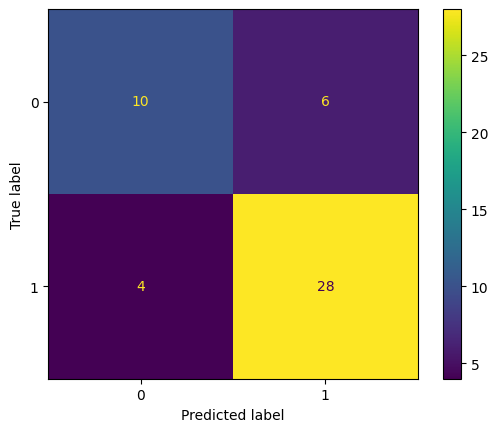

In [30]:
# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Compute metrics
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

# Prepare results
results = f"""Confusion Matrix:
{cm}

Metrics:
Precision: {precision:.4f}
Recall: {recall:.4f}
F1 Score: {f1_score:.4f}
Accuracy: {accuracy:.4f}
False Positive Rate (FPR): {fpr:.4f}
False Negative Rate (FNR): {fnr:.4f}
"""

# Save results to a text file
file_path = "./confusion_matrix_ff_100epochs.txt"
with open(file_path, "w") as file:
    file.write(results)

# Print results
print(results)

# Display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig('./confusion_matrix_ff_100epochs')
plt.show()


## Plot Prediction Curves

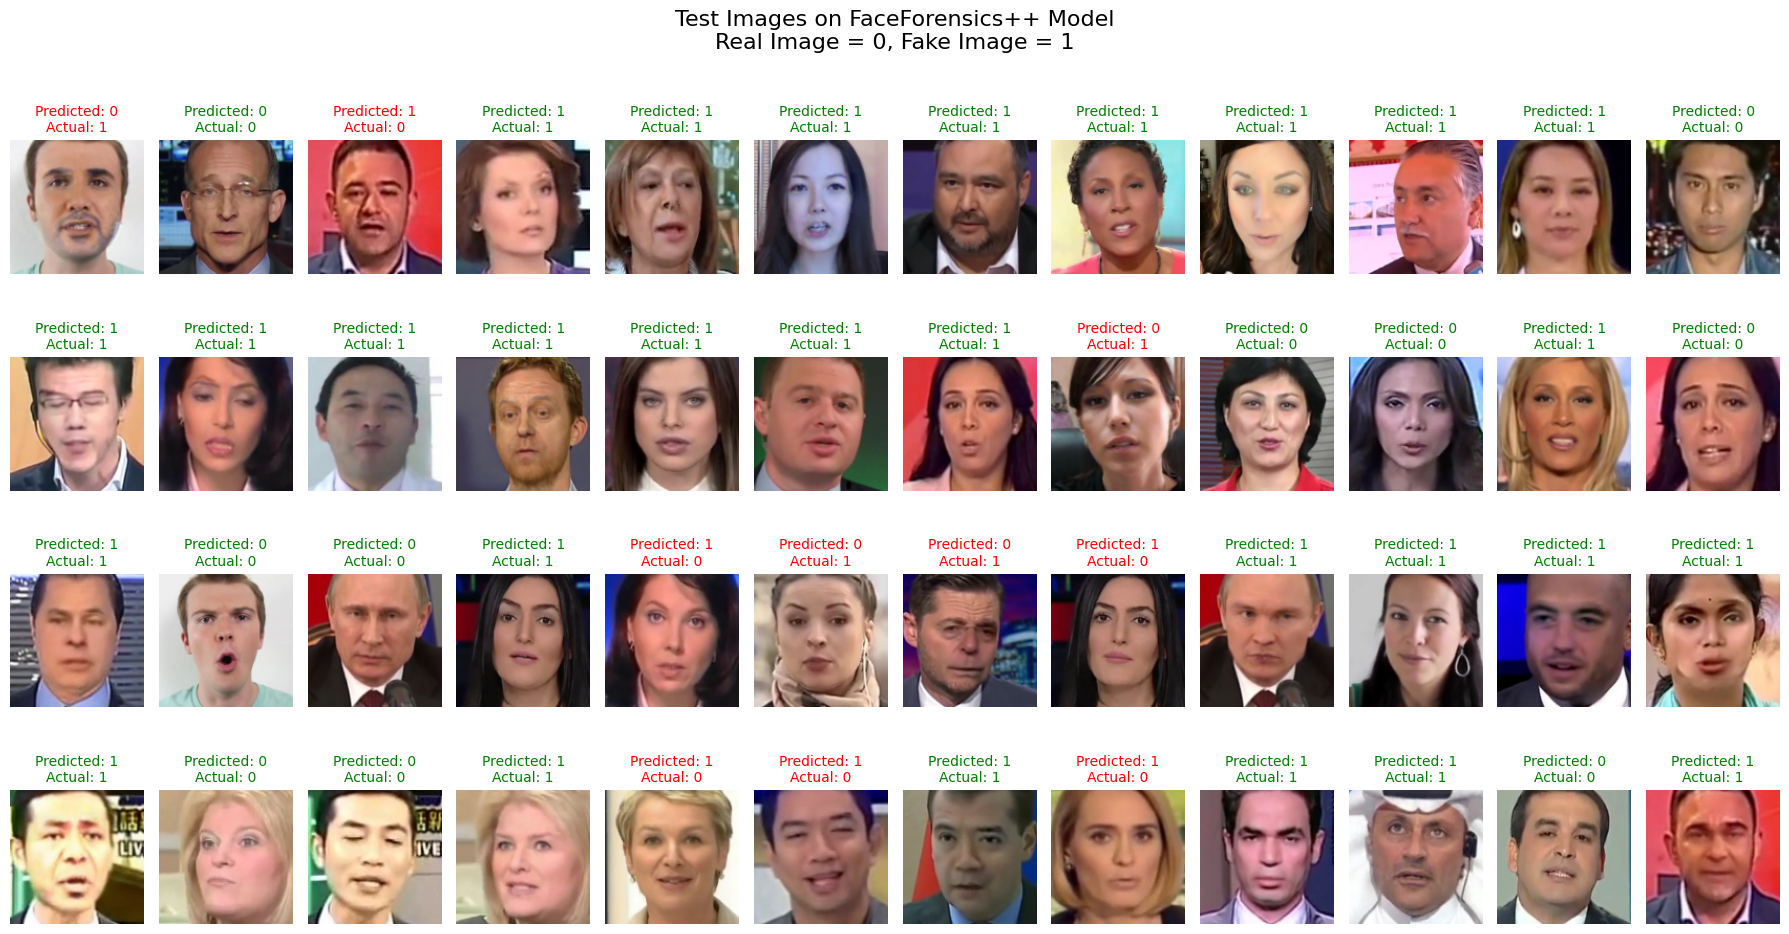

In [31]:
def plot_test_images(test_data_loader, predicted_labels, actual_labels):
    """
    Displays test images with predicted and actual labels.
    
    Parameters:
    - test_data_loader: PyTorch DataLoader object containing test data.
    - predicted_labels: List or array of predicted labels.
    - actual_labels: List or array of actual labels.
    """
    # Get the total length of the dataset
    num_images = len(test_data_loader.dataset)
    
    predicted_labels = np.array(predicted_labels)
    actual_labels = np.array(actual_labels)
    
    num_images = min(num_images, len(predicted_labels), len(actual_labels))
    
    cols = 12  # Set the number of columns to 12
    rows = (num_images + cols - 1) // cols  # Dynamically calculate the number of rows
    fig, axs = plt.subplots(rows, cols, figsize=(18, 10))  # Increase figure size
    fig.suptitle('Test Images on FaceForensics++ Model\nReal Image = 0, Fake Image = 1', fontsize=16)
    
    axs = axs.flatten()
    
    img_idx = 0  # Image counter
    for batch in test_data_loader:
        data, labels = batch  # Retrieve data and labels
        batch_size = data.size(0)
        
        for i in range(batch_size):
            if img_idx >= num_images:
                break  # Desired number of images displayed
            
            # Move the image to CPU and convert to a NumPy array
            image = data[i].cpu().numpy().transpose((1, 2, 0))
            
            # Normalize the image to the range [0, 1] (if needed)
            image = np.clip(image, 0, 1)
            
            # Add the image to the subplot
            axs[img_idx].imshow(image)
            axs[img_idx].axis('off')  # Hide axes
            
            # Add predicted and actual labels as the title
            predicted = predicted_labels[img_idx]
            actual = actual_labels[img_idx]
            title_color = 'green' if predicted == actual else 'red'  # Green if correct, red if incorrect
            axs[img_idx].set_title(f'Predicted: {predicted}\nActual: {actual}', fontsize=10, color=title_color)
            
            img_idx += 1  # Increment the counter
    
        if img_idx >= num_images:
            break  # Desired number of images displayed
    
    # Hide remaining subplots (if any)
    for j in range(img_idx, len(axs)):
        axs[j].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Leave space for the overall title
    plt.savefig("predicted_ff_100epochs.png")
    plt.show()


plot_test_images(test_data_loader, predicted_labels, actual_labels)


## Load the trained Hybrid (XceptionNet + Celeb-DF-v2 + FaceForensics++) model

In [32]:
checkpoint = torch.load('./Hybrid_100epochs.pt',map_location=torch.device('cuda'))
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [33]:
class CustomDataset(Dataset):
	def __init__(self, transform=None):
		self.imgs_path = '/home/utku/AI-Powered-Deepfake-Detection/Hybrid_test/'
		self.transform = transform
		file_list = glob.glob(self.imgs_path + "*")
		
		self.data = []
		for class_path in file_list:
			# class_name = class_path.split("\\")[-1]
			class_name = class_path.split("/")[-1]
			print(class_name)
			for img_path in glob.glob(class_path + "/*.jpg"):
				self.data.append([img_path, class_name])
			
		self.class_map = {"Real": 0, "Fake": 1}
	
	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		img_path, class_name = self.data[idx]
		img = read_image(img_path)
		class_id = self.class_map[class_name]
		class_id = torch.tensor([class_id])

		if self.transform:
				img_tensor = self.transform(img)
		return img_tensor, class_id

In [34]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
     ])

dataset = CustomDataset(transform=train_transforms)
train_size = 0
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])	

train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_data_loader)

Real
Fake


96

## Evaluation and Prediction on model

In [35]:
model.eval()
predicted_labels = []
actual_labels = []
predicted_probabilities = []

with torch.no_grad():
    for i, data in enumerate(test_data_loader):
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        output = torch.sigmoid(output)
        predicted_label = (output > 0.5).int()

        predicted_probabilities.append(output.item()) # Keeping the probabilities for ROC Curve
        predicted_labels.append(predicted_label.item())
        actual_labels.append(labels.item())
        print(f"{output.item()}, Predicted: {'Fake' if predicted_label.item() == 1 else 'Real'}, Actual: {'Fake' if labels.item() == 1 else 'Real'}")

1.0, Predicted: Fake, Actual: Fake
8.775964488449972e-06, Predicted: Real, Actual: Real
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Real
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
0.999996542930603, Predicted: Fake, Actual: Real
0.9999995231628418, Predicted: Fake, Actual: Fake
0.9999997615814209, Predicted: Fake, Actual: Fake
3.8323432818287984e-05, Predicted: Real, Actual: Real
0.6982215046882629, Predicted: Fake, Actual: Real
1.0132464012713172e-05, Predicted: Real, Actual: Real
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
0.999795138835907, Predicted: Fake, Actual: Fake
4.236008805946767e-07, Predicted: Real, Actual: Real
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicted: Fake, Actual: Fake
1.0, Predicte

In [36]:
print("Predicted labels:")
print(predicted_labels[:20])
print("Actual labels:")
print(actual_labels[:20])

print(classification_report(actual_labels, predicted_labels))

Predicted labels:
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
Actual labels:
[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
              precision    recall  f1-score   support

           0       1.00      0.53      0.69        32
           1       0.81      1.00      0.90        64

    accuracy                           0.84        96
   macro avg       0.91      0.77      0.79        96
weighted avg       0.87      0.84      0.83        96



## Show Confusion Matrix

Confusion Matrix:
[[17 15]
 [ 0 64]]

Metrics:
Precision: 0.8101
Recall: 1.0000
F1 Score: 0.8951
Accuracy: 0.8438
False Positive Rate (FPR): 0.4688
False Negative Rate (FNR): 0.0000



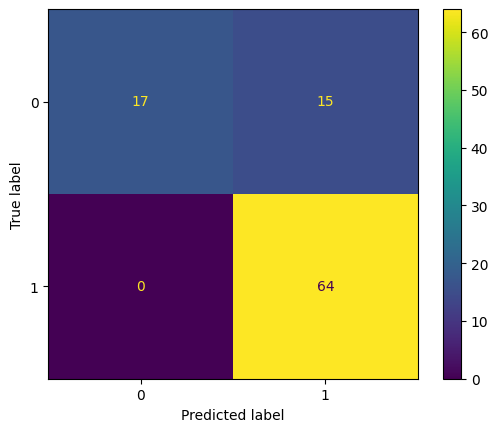

In [37]:
# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Compute metrics
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

# Prepare results
results = f"""Confusion Matrix:
{cm}

Metrics:
Precision: {precision:.4f}
Recall: {recall:.4f}
F1 Score: {f1_score:.4f}
Accuracy: {accuracy:.4f}
False Positive Rate (FPR): {fpr:.4f}
False Negative Rate (FNR): {fnr:.4f}
"""

# Save results to a text file
file_path = "./confusion_matrix_hybrid_100epochs.txt"
with open(file_path, "w") as file:
    file.write(results)

# Print results
print(results)

# Display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig('./confusion_matrix_hybrid_100epochs')
plt.show()


## Plot Prediction Curves

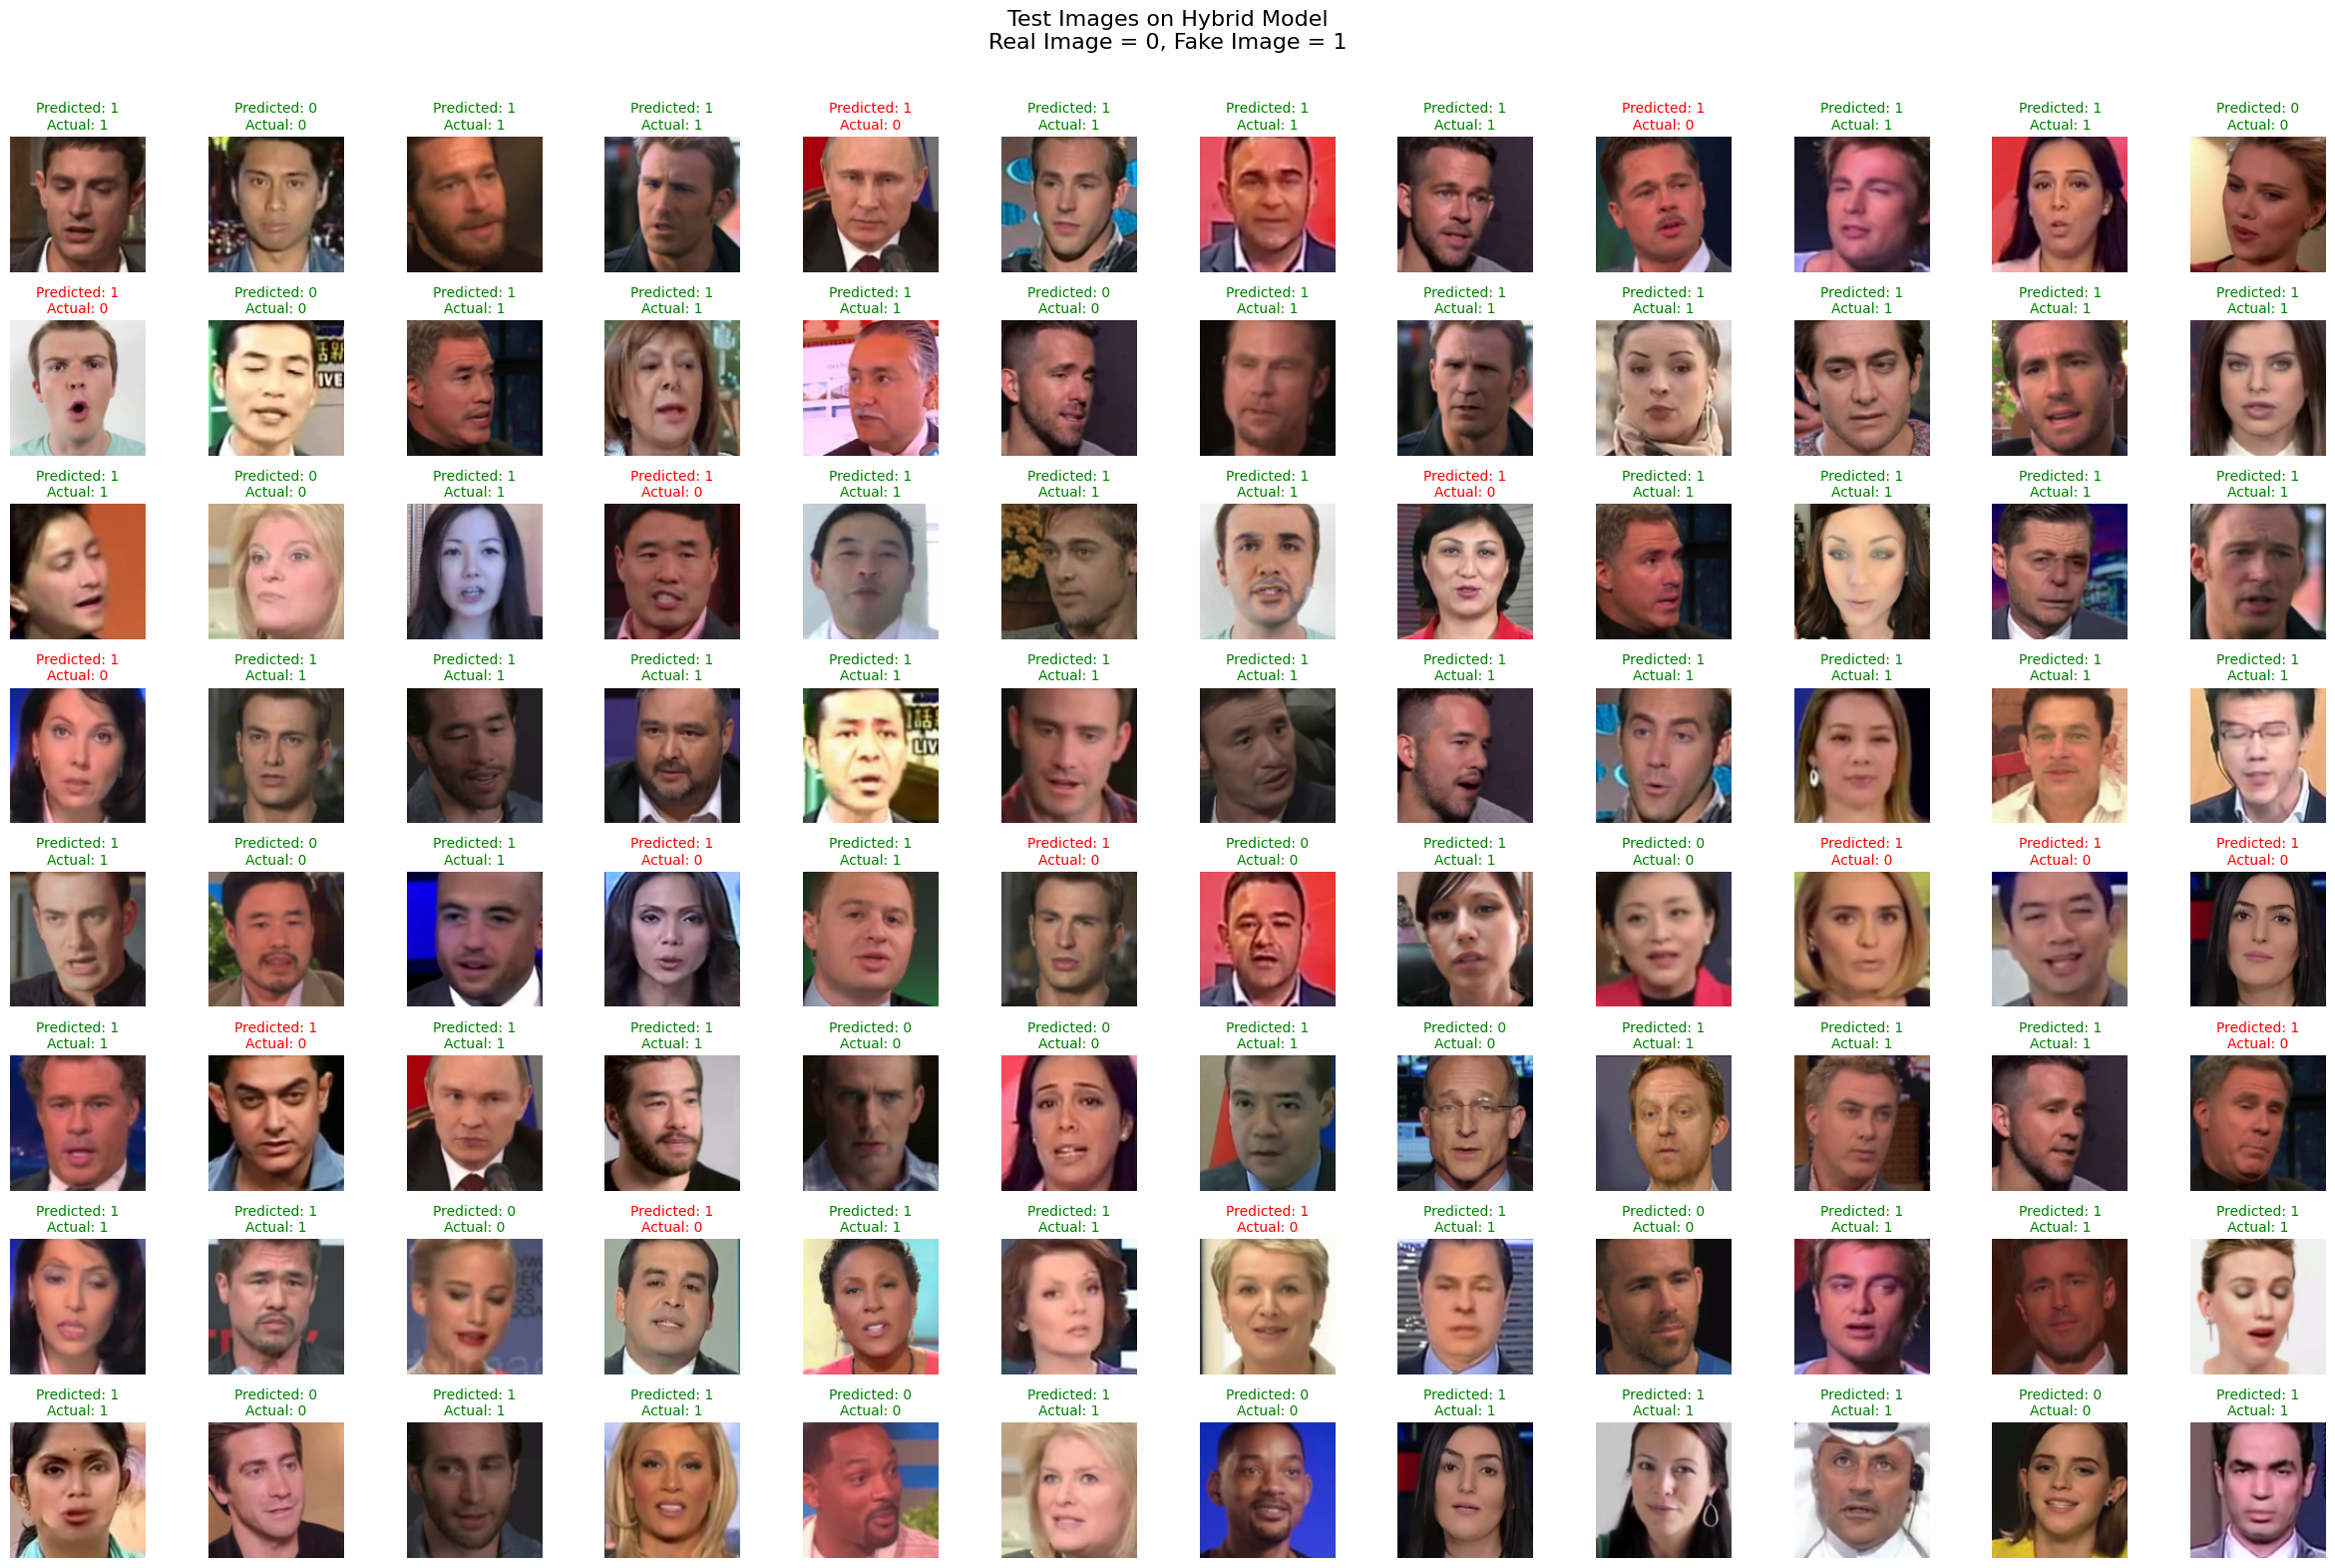

In [43]:
def plot_test_images(test_data_loader, predicted_labels, actual_labels):
    """
    Displays test images with predicted and actual labels.
    
    Parameters:
    - test_data_loader: PyTorch DataLoader object containing test data.
    - predicted_labels: List or array of predicted labels.
    - actual_labels: List or array of actual labels.
    """
    # Get the total length of the dataset
    num_images = len(test_data_loader.dataset)
    
    predicted_labels = np.array(predicted_labels)
    actual_labels = np.array(actual_labels)
    
    # Limit the number of images to 96 for the 8x12 layout
    num_images = min(num_images, len(predicted_labels), len(actual_labels), 96)
    
    cols = 12  # Set the number of columns to 12
    rows = 8   # Set the number of rows to 8
    fig, axs = plt.subplots(rows, cols, figsize=(24, 16))  # Adjust figure size for 8x12 layout
    fig.suptitle('Test Images on Hybrid Model\nReal Image = 0, Fake Image = 1', fontsize=16)
    
    axs = axs.flatten()
    
    img_idx = 0  # Image counter
    for batch in test_data_loader:
        data, labels = batch  # Retrieve data and labels
        batch_size = data.size(0)
        
        for i in range(batch_size):
            if img_idx >= num_images:
                break  # Desired number of images displayed
            
            # Move the image to CPU and convert to a NumPy array
            image = data[i].cpu().numpy().transpose((1, 2, 0))
            
            # Normalize the image to the range [0, 1] (if needed)
            image = np.clip(image, 0, 1)
            
            # Add the image to the subplot
            axs[img_idx].imshow(image)
            axs[img_idx].axis('off')  # Hide axes
            
            # Add predicted and actual labels as the title
            predicted = predicted_labels[img_idx]
            actual = actual_labels[img_idx]
            title_color = 'green' if predicted == actual else 'red'  # Green if correct, red if incorrect
            axs[img_idx].set_title(f'Predicted: {predicted}\nActual: {actual}', fontsize=10, color=title_color)
            
            img_idx += 1  # Increment the counter
    
        if img_idx >= num_images:
            break  # Desired number of images displayed
    
    # Hide remaining subplots (if any)
    for j in range(img_idx, len(axs)):
        axs[j].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Leave space for the overall title
    plt.savefig("predicted_hybrid_100epochs.png")
    plt.show()


plot_test_images(test_data_loader, predicted_labels, actual_labels)
